In [1]:
import spacetimeformer as stf
import pytorch_lightning as pl
import numpy as np
from scipy.stats import chi2, norm, beta, gamma
import matplotlib.pyplot as plt
import math
import pandas as pd
from connection_complexity.data.raw_data.EDF.edf_helpers import read_edf
import sys
from contextlib import contextmanager


In [2]:
default_config = {
    # fixed but maybe change...
    'batch_size': 2000,
    'workers': 6,
    'init_lr': 1e-10,
    'base_lr': 0.0005,
    'context_points': 32,
    'target_points': 1,
    'd_model': 100,
    'd_qk': 100,
    'd_v': 100,
    'd_ff': 400,
    'n_heads': 1,
    'enc_layers': 1,
    'dec_layers': 1,
    'global_self_attn': 'full',
    'local_self_attn': 'full',
    'global_cross_attn': 'full',
    'local_cross_attn': 'full',
    'no_val': False,
    'no_time': False,
    'no_space': False,
    'no_given': False,

    # directly set parameters
    'gpus': [0],
    # 'gpus':None,
    'strategy': 'dp',
    "time_resolution": 1,
    "start_token_len": 0,
    "attn_factor": 5,
    "dropout_emb": 0.2,
    "dropout_attn_out": 0,
    "dropout_attn_matrix": 0,
    "dropout_qkv": 0,
    "dropout_ff": 0.3,
    "pos_emb_type": 'abs',
    "no_final_norm": False,
    "performer_kernel": 'relu',
    "performer_redraw_interval": 100,
    "attn_time_windows": 1,
    "use_shifted_time_windows": False,
    "norm": 'batch',
    "activation": 'gelu',
    "warmup_steps": 0,
    "decay_factor": 0.25,
    "initial_downsample_convs": 0,
    "intermediate_downsample_convs": 0,
    "embed_method": 'spatio-temporal',
    "l2_coeff": 0.000001,
    "loss": 'mse',
    "class_loss_imp": 0.1,
    "recon_loss_imp": 0,
    "time_emb_dim": 3,
    "null_value": None,
    "pad_value": None,
    "linear_window": 0,
    "use_revin": False,
    "linear_shared_weights": False,
    "use_seasonal_decomp": False,
    "recon_mask_skip_all": 1,
    "recon_mask_max_seq_len": 5,
    "recon_mask_drop_seq": 0.2,
    "recon_mask_drop_standard": 0.1,
    "recon_mask_drop_full": 0.05,
    "grad_clip_norm": 0.0,
    "accumulate": 1,
    "limit_val_batches": 1.0,
    "max_epochs": 10,
    "val_check_interval": 1.0,
}

def create_model(config, x_dim, yc_dim, yt_dim):
    max_seq_len = config['context_points'] + config['target_points']

    forecaster = stf.spacetimeformer_model.Spacetimeformer_Forecaster(
        d_x=x_dim,
        d_yc=yc_dim,
        d_yt=yt_dim,
        max_seq_len=max_seq_len,
        start_token_len=config['start_token_len'],
        attn_factor=config['attn_factor'],
        d_model=config['d_model'],
        d_queries_keys=config['d_qk'],
        d_values=config['d_v'],
        n_heads=config['n_heads'],
        e_layers=config['enc_layers'],
        d_layers=config['dec_layers'],
        d_ff=config['d_ff'],
        dropout_emb=config['dropout_emb'],
        dropout_attn_out=config['dropout_attn_out'],
        dropout_attn_matrix=config['dropout_attn_matrix'],
        dropout_qkv=config['dropout_qkv'],
        dropout_ff=config['dropout_ff'],
        pos_emb_type=config['pos_emb_type'],
        use_final_norm=not config['no_final_norm'],
        global_self_attn=config['global_self_attn'],
        local_self_attn=config['local_self_attn'],
        global_cross_attn=config['global_cross_attn'],
        local_cross_attn=config['local_cross_attn'],
        performer_kernel=config['performer_kernel'],
        performer_redraw_interval=config['performer_redraw_interval'],
        attn_time_windows=config['attn_time_windows'],
        use_shifted_time_windows=config['use_shifted_time_windows'],
        norm=config['norm'],
        activation=config['activation'],
        init_lr=config['init_lr'],
        base_lr=config['base_lr'],
        warmup_steps=config['warmup_steps'],
        decay_factor=config['decay_factor'],
        initial_downsample_convs=config['initial_downsample_convs'],
        intermediate_downsample_convs=config['intermediate_downsample_convs'],
        embed_method=config['embed_method'],
        l2_coeff=config['l2_coeff'],
        loss=config['loss'],
        class_loss_imp=config['class_loss_imp'],
        recon_loss_imp=config['recon_loss_imp'],
        time_emb_dim=config['time_emb_dim'],
        null_value=config['null_value'],
        pad_value=config['pad_value'],
        linear_window=config['linear_window'],
        use_revin=config['use_revin'],
        linear_shared_weights=config['linear_shared_weights'],
        use_seasonal_decomp=config['use_seasonal_decomp'],
        use_val=not config['no_val'],
        use_time=not config['no_time'],
        use_space=not config['no_space'],
        use_given=not config['no_given'],
        recon_mask_skip_all=config['recon_mask_skip_all'],
        recon_mask_max_seq_len=config['recon_mask_max_seq_len'],
        recon_mask_drop_seq=config['recon_mask_drop_seq'],
        recon_mask_drop_standard=config['recon_mask_drop_standard'],
        recon_mask_drop_full=config['recon_mask_drop_full'],
    )
    return forecaster

def s1_data(config, m=1):
    fs = 2048  # Sampling rate (Hz)
    T = 150  # Length of epochs (s)

    # Set the seed for reproducibility
    np.random.seed(0)

    # Define the number of iterations for the simulation
    n_iterations = fs * T
    # Preallocate the arrays for the x variables
    x1 = np.zeros(n_iterations)
    x2 = np.zeros(n_iterations)
    x3 = np.zeros(n_iterations)
    x4 = np.zeros(n_iterations)
    x5 = np.zeros(n_iterations)

    # Define the rate lambda for the exponential distribution
    lambda_rate = 2

    # Generate the noise processes e1t, e2t, e3t, e4t, e5t
    e1 = np.random.exponential(scale=1 / lambda_rate, size=n_iterations)
    e2 = chi2.rvs(df=1, size=n_iterations)
    e3 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e4 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e5 = norm.rvs(scale=1, size=n_iterations) *m# Gaussian with mean 0, std 1

    for t in range(0, n_iterations):
        # Generate the x variables based on the given equations
        x1[t] = e1[t]
        x2[t] = e2[t]
        x3[t] = 0.8 * x2[t] + e3[t]
        x4[t] = 0.7 * x1[t] * (math.pow(x1[t], 2) - 1) * np.exp((-math.pow(x1[t], 2)) / 2) + e4[t]
        x5[t] = 0.3 * x2[t] + 0.05 * math.pow(x2[t], 2) + e5[t]

    # After the loop, x1t, x2t, x3t, x4t, and x5t contain the simulation data.

    PLOT_VAR_NAMES = np.arange(5) + 1
    PLOT_VAR_IDxS = np.arange(5)

    data = np.array([x1, x2, x3, x4, x5]).T

    df = pd.DataFrame(data, columns=PLOT_VAR_NAMES)
    df["Datetime"] = pd.date_range(start="1/1/2020", periods=df.shape[0], freq="ms")

    dset = stf.data.CSVTimeSeries(
        data_path=None,
        raw_df=df,
        val_split=0.1,
        test_split=0.1,
        normalize=True,
        time_col_name="Datetime",
        time_features=["minute", 'second', 'millisecond'],
    )
    yc_dim = data.shape[1]
    yt_dim = data.shape[1]
    x_dim = dset.time_cols.shape[0]

    DATA_MODULE = stf.data.DataModule(
        datasetCls=stf.data.CSVTorchDset,
        dataset_kwargs={
            "csv_time_series": dset,
            "context_points": config['context_points'],
            "target_points": config['target_points'],
            "time_resolution": config['time_resolution'],
        },
        batch_size=config['batch_size'],
        workers=config['workers'],
        overfit=False,
    )
    INV_SCALER = dset.reverse_scaling
    SCALER = dset.apply_scaling
    NULL_VAL = None
    return DATA_MODULE

def s2_data(config):
    fs = 2048  # Sampling rate (Hz)
    T = 150  # Length of epochs (s)

    # Set the seed for reproducibility
    np.random.seed(0)

    # Define the number of iterations for the simulation
    n_iterations = fs * T

    # Preallocate the arrays for the x variables
    x1 = np.zeros(n_iterations)
    x2 = np.zeros(n_iterations)
    x3 = np.zeros(n_iterations)
    x4 = np.zeros(n_iterations)
    x5 = np.zeros(n_iterations)

    # Define the rate lambda for the exponential distribution
    lambda_rate = 2

    # Generate the noise processes e1t, e2t, e3t, e4t, e5t
    e1 = norm.rvs(scale=1, size=n_iterations)  # Gaussian with mean 0, std 1
    e2 = np.random.exponential(scale=1 / lambda_rate, size=n_iterations)
    e3 = beta.rvs(a=1, b=2, size=n_iterations)
    e4 = beta.rvs(a=2, b=1, size=n_iterations)
    e5 = norm.rvs(scale=1, size=n_iterations)  # Gaussian with mean 0, std 1

    for t in range(3, n_iterations):
        # Generate the x variables based on the given equations
        x1[t] = 0.7 * x1[t - 1] + e1[t]
        x2[t] = 0.3 * np.power(x1[t - 2], 2) + e2[t]
        x3[t] = 0.4 * x1[t - 3] - 0.3 * x3[t - 2] + e3[t]
        x4[t] = 0.7 * x4[t - 1] - 0.3 * x5[t - 1] * np.exp((-math.pow(x5[t - 1], 2)) / 2) + e4[t]
        x5[t] = 0.5 * x4[t - 1] + 0.2 * x5[t - 2] + e5[t]

    data = np.array([x1, x2, x3, x4, x5]).T
    PLOT_VAR_NAMES = np.arange(5) + 1
    PLOT_VAR_IDxS = np.arange(5)
    df = pd.DataFrame(data, columns=PLOT_VAR_NAMES)
    df["Datetime"] = pd.date_range(start="1/1/2020", periods=df.shape[0], freq="ms")

    dset = stf.data.CSVTimeSeries(
        data_path=None,
        raw_df=df,
        val_split=0.2,
        test_split=0.2,
        normalize=True,
        time_col_name="Datetime",
        time_features=["minute", 'second', 'millisecond'],
    )
    yc_dim = data.shape[1]
    yt_dim = data.shape[1]
    x_dim = dset.time_cols.shape[0]

    DATA_MODULE = stf.data.DataModule(
        datasetCls=stf.data.CSVTorchDset,
        dataset_kwargs={
            "csv_time_series": dset,
            "context_points": config['context_points'],
            "target_points": config['target_points'],
            "time_resolution": config['time_resolution'],
        },
        batch_size=config['batch_size'],
        workers=config['workers'],
        overfit=False,
    )

    return DATA_MODULE

def ar_data(config, m=1, return_data=False):
    fs = 2048  # Sampling rate (Hz)
    T = 150  # Length of epochs (s)

    # Set the seed for reproducibility
    np.random.seed(42)

    # Define the number of iterations for the simulation
    n_iterations = fs * T
    # Preallocate the arrays for the x variables
    x1 = np.zeros(n_iterations)
    x2 = np.zeros(n_iterations)
    x3 = np.zeros(n_iterations)
    x4 = np.zeros(n_iterations)
    x5 = np.zeros(n_iterations)

    # Define the rate lambda for the exponential distribution
    lambda_rate = 2

    # Generate the noise processes e1t, e2t, e3t, e4t, e5t
    e1 = np.random.exponential(scale=1 / lambda_rate, size=n_iterations)
    e2 = chi2.rvs(df=1, size=n_iterations)
    # e1 = norm.rvs(scale=1, size=n_iterations)
    # e2 = norm.rvs(scale=1, size=n_iterations)
    e3 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e4 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
    e5 = norm.rvs(scale=1, size=n_iterations) *m# Gaussian with mean 0, std 1

    for t in range(6, n_iterations):
        # Generate the x variables based on the given equations
        x1[t] = 0.05 * x1[t-5] - 0.15 * x1[t-4] + 0.25 * x1[t-3] - 0.35 * x1[t-2] + 0.45 * x1[t-1] + e1[t]
        # x1[t] = e1[t]

        x2[t] = - 0.01 * x2[t-6] + .09 * x2[t-5] - 0.2 * x2[t-4] + .27 * x2[t-3] - 0.35 * x2[t-2] + .4 * x2[t-1] + e2[t]
        x3[t] = 0.8 * x2[t] + e3[t]
        x4[t] = 0.7 * x1[t] * (math.pow(x1[t], 2) - 1) * np.exp((-math.pow(x1[t], 2)) / 2) + e4[t]
        x5[t] = 0.3 * x2[t] + 0.05 * math.pow(x2[t], 2) + e5[t]

    # After the loop, x1t, x2t, x3t, x4t, and x5t contain the simulation data.

    PLOT_VAR_NAMES = np.arange(5) + 1
    PLOT_VAR_IDxS = np.arange(5)

    data = np.array([x1, x2, x3, x4, x5]).T
    data= data[100:]
    df = pd.DataFrame(data, columns=PLOT_VAR_NAMES)

    df["Datetime"] = pd.date_range(start="1/1/2020", periods=df.shape[0], freq="s")

    dset = stf.data.CSVTimeSeries(
        data_path=None,
        raw_df=df,
        val_split=0.1,
        test_split=0.1,
        normalize=True,
        time_col_name="Datetime",
        time_features=["hour", 'minute', 'second'],
    )
    yc_dim = data.shape[1]
    yt_dim = data.shape[1]
    x_dim = dset.time_cols.shape[0]

    DATA_MODULE = stf.data.DataModule(
        datasetCls=stf.data.CSVTorchDset,
        dataset_kwargs={
            "csv_time_series": dset,
            "context_points": config['context_points'],
            "target_points": config['target_points'],
            "time_resolution": config['time_resolution'],
        },
        batch_size=config['batch_size'],
        workers=config['workers'],
        overfit=False,
    )
    INV_SCALER = dset.reverse_scaling
    SCALER = dset.apply_scaling
    NULL_VAL = None
    if return_data:
        return data
    return DATA_MODULE

def unique_waveform_values(data):
    '''
    data should be a 2D array with shape (n_samples, n_waves)
    '''
    unique = []
    totalUnique = set()
    for i in range(data.shape[1]):
        unique.append(set(np.unique(data[:,i])))
        totalUnique = totalUnique.union(unique[i])
    nUnique = np.array([len(u) for u in unique])
    return unique, nUnique, totalUnique

@contextmanager
def suppress_stdout():
    original_stdout = sys.stdout  # Save the original stdout
    try:
        sys.stdout = SuppressOutput()  # Suppress printing
        yield
    finally:
        sys.stdout = original_stdout  # Restore the original stdout

class SuppressOutput:
    def write(self, _):
        pass
    def flush(self):
        pass 

trainer = pl.Trainer(
        gpus=default_config['gpus'],
        callbacks=[],

        accelerator="dp",
        gradient_clip_val=default_config['grad_clip_norm'],
        gradient_clip_algorithm="norm",
        overfit_batches= 0,
        accumulate_grad_batches=default_config['accumulate'],
        sync_batchnorm=False,
        limit_val_batches=default_config['limit_val_batches'],
        max_epochs=default_config['max_epochs'],
        log_every_n_steps=1,
        val_check_interval = default_config['val_check_interval'],
    )


/home/wendeldr/miniconda3/envs/stf/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:287: LightningDeprecationWarning: Passing `Trainer(accelerator='dp')` has been deprecated in v1.5 and will be removed in v1.7. Use `Trainer(strategy='dp')` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [3]:
# read edf file
eeg = read_edf('/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/OvertNaming.EDF', preload=True)
edf_data = eeg.get_data()

print('EDF data shape (channels, samples): ')
print(edf_data.shape)

# network system of 5 variables
data_module = ar_data(default_config)
system_train_data = data_module.dataset_kwargs['csv_time_series'].train_data[[1,2,3,4,5]].values
system_test_data = data_module.dataset_kwargs['csv_time_series'].test_data[[1,2,3,4,5]].values
system_val_data = data_module.dataset_kwargs['csv_time_series'].val_data[[1,2,3,4,5]].values

print('\nSystem train data shape:')
print(f'Train: {system_train_data.T.shape}')
print(f'Test: {system_test_data.T.shape}')
print(f'Val: {system_val_data.T.shape}')
print(f'Total data: {system_train_data.T.shape[1] + system_test_data.T.shape[1] + system_val_data.T.shape[1]}')

EDF data shape (channels, samples): 
(164, 331008)

System train data shape:
Train: (5, 245680)
Test: (5, 30710)
Val: (5, 30710)
Total data: 307100


In [4]:
edf_unique, N_edf_unique, edf_unique_total = unique_waveform_values(edf_data.T)
system_train_unique, N_strain_unique, strain_total = unique_waveform_values(system_train_data)
system_test_unique, N_stest_unique, stest_total = unique_waveform_values(system_test_data)
system_val_unique, N_sval_unique, sval_total = unique_waveform_values(system_val_data)

In [5]:
print('Number of unique values for each channel in the EDF data: ')
print(N_edf_unique)
print(f"mean: {np.mean(N_edf_unique)}")
print('Number of unique values in whole EDF: ')
print(len(edf_unique_total))

print('\n-------------\n')
print('Number of unique values for each variable in the system train data: ')
print(N_strain_unique)
print(f"mean: {np.mean(N_strain_unique)}")
print('Number of unique values in whole system train data: ')
print(len(strain_total))
print('\n=============\n')
print('Number of unique values for each variable in the system test data: ')
print(N_stest_unique)
print(f"mean: {np.mean(N_stest_unique)}")
print('Number of unique values in whole system test data: ')
print(len(stest_total))
print('\n=============\n')
print('Number of unique values for each variable in the system val data: ')
print(N_sval_unique)
print(f"mean: {np.mean(N_sval_unique)}")
print('Number of unique values in whole system val data: ')
print(len(sval_total))



Number of unique values for each channel in the EDF data: 
[ 3945  3134  2971  3543  5651  6161  4158  7535  6298  3593  2163  2165
  2129  3686  4398  4716  3153  5451  6864  4872  2865  3881  2056  2099
  2027  2076  2162  2715  4205  2380  2109  2173  2439  2287  2259  2185
  2183  2226  2306  2458  3067  4299  5270  5973  5514  2922  2625  4162
  2416  2276  2436  2172  2487  2529  2284  2162  2154  2198  2315  2457
  2705  2962  2134  2156  2328  2822  3845  5605  2450  2949  6005  2641
  2204  2105  2512  3096  3640  3934  3948  3783  3583  3423  3098  2078
  2107  2163  2338  2683  3270  3673  3678  3484  1958  2081  3235  2282
  3990  3817  3649  3759  4320  3858  2147  2337  2401  2335  2074  1948
  1997  2161  3239  2635  2199  2098  1865  1850  1841  1876  1861  1879
  1891  1949  1999  2096  2895  2586  2564  2130  2045  2374  2674  2667
  2473  2712  2384  2503  2659  2683  1958  2329  3076  3162  3313  2705
 11305  3439  2059  2031  2006  2173  2640  3499  2864  2689  197

In [6]:
# Do predictions match the training data?
path = '/home/wendeldr/git/spacetimeformer/spacetimeformer/data/STF_LOG_DIR/F_S1_1_m0_b82d547a/F_S1_1_m0epoch=27.ckpt'

with suppress_stdout():
    model = create_model(default_config, 3, 5, 5)
    model.set_inv_scaler(data_module.dataset_kwargs['csv_time_series'].reverse_scaling)
    model.set_scaler(data_module.dataset_kwargs['csv_time_series'].apply_scaling)
    model.set_null_value(None)
    model = model.load_from_checkpoint(path)
    model.to("cuda")

In [7]:
# predictions = None
# for i, data in enumerate(iter(data_module.test_dataloader())):
#     xc, yc, xt, truth = data
#     yt_pred = model.predict(xc, yc, xt, scale_input=False, scale_output=False,)
#     yt_pred = yt_pred.detach().cpu().numpy()
#     yt_pred = yt_pred.reshape(-1, 5)
#     if predictions is None:
#         predictions = yt_pred
#     else:
#         predictions = np.concatenate((predictions, yt_pred), axis=0)


In [8]:
# predictions.shape

In [9]:
# pred_unique, N_pred_unique, pred_unique_total = unique_waveform_values(predictions)
# print('Number of unique values for each channel in the prediction data: ')
# print(N_pred_unique)
# print(f"mean: {np.mean(N_pred_unique)}")
# print('Number of unique values in all predictions: ')
# print(len(pred_unique_total))

In [10]:
# ns = []
# for t, p in zip(system_train_unique, pred_unique):
#     overlap = t.intersection(p)
#     nunique_to_t = t.difference(p)
#     nunique_to_p = p.difference(t)
#     ns.append((len(overlap), len(nunique_to_t), len(nunique_to_p)))
# ns = pd.DataFrame(ns, columns=['overlap', 'nunique_to_t', 'nunique_to_p'])
# print(ns)

In [11]:
m = 0.5
fs = 2048  # Sampling rate (Hz)
T = 150  # Length of epochs (s)

# Set the seed for reproducibility
np.random.seed(42)

# Define the number of iterations for the simulation
n_iterations = fs * T
# Preallocate the arrays for the x variables
x1 = np.zeros(n_iterations)
x2 = np.zeros(n_iterations)
x3 = np.zeros(n_iterations)
x4 = np.zeros(n_iterations)
x5 = np.zeros(n_iterations)

# Define the rate lambda for the exponential distribution
lambda_rate = 2

# Generate the noise processes e1t, e2t, e3t, e4t, e5t
e1 = np.random.exponential(scale=1 / lambda_rate, size=n_iterations)
e2 = chi2.rvs(df=1, size=n_iterations)
# e1 = norm.rvs(scale=1, size=n_iterations)
# e2 = norm.rvs(scale=1, size=n_iterations)
e3 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
e4 = norm.rvs(scale=1, size=n_iterations) *m # Gaussian with mean 0, std 1
e5 = norm.rvs(scale=1, size=n_iterations) *m# Gaussian with mean 0, std 1

for t in range(6, n_iterations):
    # Generate the x variables based on the given equations
    # x1[t] = 0.05 * x1[t-5] - 0.15 * x1[t-4] + 0.25 * x1[t-3] - 0.35 * x1[t-2] + 0.45 * x1[t-1] + e1[t]
    # x2[t] = - 0.01 * x2[t-6] + .09 * x2[t-5] - 0.2 * x2[t-4] + .27 * x2[t-3] - 0.35 * x2[t-2] + .4 * x2[t-1] + e2[t]
    x1[t] = e1[t]
    x2[t] = e2[t]
    x3[t] = 0.8 * x2[t] + e3[t]
    x4[t] = 0.7 * x1[t] * (math.pow(x1[t], 2) - 1) * np.exp((-math.pow(x1[t], 2)) / 2) + e4[t]
    x5[t] = 0.3 * x2[t] + 0.05 * math.pow(x2[t], 2) + e5[t]

org_data = np.array([x1, x2, x3, x4, x5]).T

In [12]:
sigfig = 3

# quantize the original data at loop on each variable use
q1_1 = np.zeros(n_iterations)
q1_2 = np.zeros(n_iterations)
q1_3 = np.zeros(n_iterations)
q1_4 = np.zeros(n_iterations)
q1_5 = np.zeros(n_iterations)
for t in range(6, n_iterations):
    q1_1[t] = np.round(e1[t], sigfig)
    q1_2[t] = np.round(e2[t], sigfig)
    q1_3[t] = np.round(0.8 * q1_2[t], sigfig) + np.round(e3[t], sigfig)
    q1_4[t] = np.round(0.7 * q1_1[t], sigfig) * np.round((math.pow(q1_1[t], 2) - 1), sigfig) * np.round(np.exp((-math.pow(q1_1[t], 2)) / 2), sigfig) + np.round(e4[t], sigfig)
    q1_5[t] = np.round(0.3 * q1_2[t], sigfig) + np.round(0.05 * math.pow(q1_2[t], 2), sigfig) + np.round(e5[t], sigfig)

# quantize the original data at end
q2_1 = np.round(x1, sigfig)
q2_2 = np.round(x2, sigfig)
q2_3 = np.round(x2, sigfig)
q2_4 = np.round(x4, sigfig)
q2_5 = np.round(x5, sigfig)

# quantize the original data at input round non-interacting nodes at end
q3_1 = np.zeros(n_iterations)
q3_2 = np.zeros(n_iterations)
q3_3 = np.zeros(n_iterations)
q3_4 = np.zeros(n_iterations)
q3_5 = np.zeros(n_iterations)
for t in range(6, n_iterations):
    q3_1[t] = np.round(e1[t], sigfig)
    q3_2[t] = np.round(e2[t], sigfig)
    q3_3[t] = 0.8 * q3_2[t] + np.round(e3[t], sigfig)
    q3_4[t] = 0.7 * q3_1[t] * (math.pow(q3_1[t], 2) - 1) * np.exp((-math.pow(q3_1[t], 2)) / 2) + np.round(e4[t], sigfig)
    q3_5[t] = 0.3 * q3_2[t] + 0.05 * math.pow(q3_2[t], 2) + np.round(e5[t], sigfig)

q3_3 = np.round(q3_3, sigfig)
q3_4 = np.round(q3_4, sigfig)
q3_5 = np.round(q3_5, sigfig)

q1 = np.array([q1_1, q1_2, q1_3, q1_4, q1_5]).T
q2 = np.array([q2_1, q2_2, q2_3, q2_4, q2_5]).T
q3 = np.array([q3_1, q3_2, q3_3, q3_4, q3_5]).T

In [13]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [14]:
mae1 = mae(org_data, q1)
mae2 = mae(org_data, q2)
mae3 = mae(org_data, q3)
print(f"MAE1: {mae1}")
print(f"MAE2: {mae2}")
print(f"MAE3: {mae3}")

MAE1: 0.0003341626848369485
MAE2: 0.09500271356538678
MAE3: 0.0003159100738324658


In [15]:
q3_unique, N_q3_unique, q3_unique_total = unique_waveform_values(q3)
print('Number of unique values for each channel in the q3 data: ')
print(N_q3_unique)
print(f"mean: {np.mean(N_q3_unique)}")
print('Number of unique values in all q3: ')
print(len(q3_unique_total))

Number of unique values for each channel in the q3 data: 
[3500 8686 8900 3684 8007]
mean: 6555.4
Number of unique values in all q3: 
11571


In [16]:
q1.shape

(307200, 5)

In [17]:
start = 1000
end   = start + 100

fig, ax = plt.subplots(5, 1, figsize=(20, 10))
ax[0].plot(org_data[start:end,0], label='orig')
ax[0].plot(q1[start:end,0], label='q 1')
ax[0].plot(q2[start:end,0], label='q 2')
ax[0].plot(q3[start:end,0], label='q 3')
ax[0].legend(loc='upper left')
ax[0].set_title('x1')

ax[1].plot(org_data[start:end,1], label='orig')
ax[1].plot(q1[start:end,1], label='q 1')
ax[1].plot(q2[start:end,1], label='q 2')
ax[1].plot(q3[start:end,1], label='q 3')
ax[1].set_title('x2')

ax[2].plot(org_data[start:end,2], label='orig')
ax[2].plot(q1[start:end,2], label='q 1')
ax[2].plot(q2[start:end,2], label='q 2')
ax[2].plot(q3[start:end,2], label='q 3')
ax[2].set_title('x3')

ax[3].plot(org_data[start:end,3], label='orig')
ax[3].plot(q1[start:end,3], label='q 1')
ax[3].plot(q2[start:end,3], label='q 2')
ax[3].plot(q3[start:end,3], label='q 3')
ax[3].set_title('x4')

ax[4].plot(org_data[start:end,4], label='orig')
ax[4].plot(q1[start:end,4], label='q 1')
ax[4].plot(q2[start:end,4], label='q 2')
ax[4].plot(q3[start:end,4], label='q 3')
ax[4].set_title('x5')

plt.suptitle(f'Original vs quantized data sigfig: {sigfig}');

In [18]:
data = ar_data(default_config, m=0, return_data=True)

In [19]:
from scipy.signal import correlate

def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = correlate(p, q, 'full')/ max(len(p), len(q))
    return c

In [20]:
import mne
from scipy.stats import chi2, norm, beta, gamma



np.random.seed(42)

with suppress_stdout():
    eeg1 = mne.io.read_raw_edf("/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/FC_OvertNaming.EDF", preload=True)
    eeg2 = mne.io.read_raw_edf("/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/PC_OvertNaming.EDF", preload=True)

    sf1 = eeg1.info['sfreq']
    sf2 = eeg2.info['sfreq']

    # filter 60 Hz noise and harmonics with zerophase notch filter
    eeg1 = eeg1.notch_filter(np.arange(60, sf1//2, 60), fir_design='firwin',verbose=False).get_data(picks=eeg1.info['ch_names'][0]).squeeze()
    eeg2 = eeg2.notch_filter(np.arange(60, sf2//2, 60), fir_design='firwin',verbose=False).get_data(picks=eeg2.info['ch_names'][1]).squeeze()

    # # z normalize data
    eeg1 = (eeg1 - np.mean(eeg1)) / np.std(eeg1)
    eeg2 = (eeg2 - np.mean(eeg2)) / np.std(eeg2)

# Define the number of iterations for the simulation
n_iterations = fs * T
# Preallocate the arrays for the x variables
x1 = eeg1[:n_iterations]
x2 = eeg2[:n_iterations]
# print(x1.shape)
x3 = np.zeros(n_iterations)
x4 = np.zeros(n_iterations)
x5 = np.zeros(n_iterations)

# Define the rate lambda for the exponential distribution
lambda_rate = 2

# Generate the noise processes e1t, e2t, e3t, e4t, e5t
# e1 = norm.rvs(scale=1, size=n_iterations)
# e2 = norm.rvs(scale=1, size=n_iterations)
e3 = norm.rvs(scale=1, size=n_iterations) * 0.01 
e4 = norm.rvs(scale=1, size=n_iterations) * 0 # Gaussian with mean 0, std 1
e5 = norm.rvs(scale=1, size=n_iterations) * 0# Gaussian with mean 0, std 1

for t in range(6, n_iterations):
    # Generate the x variables based on the given equations
    x4[t] = 0.7 * x1[t] * (math.pow(x1[t], 2) - 1) * np.exp((-math.pow(x1[t], 2)) / 2) + e4[t]

    x3[t] = 0.8 * x2[t] + e3[t]
    x5[t] = 0.3 * x2[t] + 0.05 * math.pow(x2[t], 2) + e5[t]

import copy
x1_org = copy.deepcopy(x1)
x2_org = copy.deepcopy(x2)
x3_org = copy.deepcopy(x3)
x4_org = copy.deepcopy(x4)
x5_org = copy.deepcopy(x5)



#==============
m  = 3
fs = 2048  # Sampling rate (Hz)
T  = 150  # Length of epochs (s)

# Set the seed for reproducibility
np.random.seed(42)

with suppress_stdout():
    eeg1 = mne.io.read_raw_edf("/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/FC_OvertNaming.EDF", preload=True)
    eeg2 = mne.io.read_raw_edf("/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/PC_OvertNaming.EDF", preload=True)

    sf1 = eeg1.info['sfreq']
    sf2 = eeg2.info['sfreq']
    # eeg1 = eeg1.get_data(picks=eeg1.info['ch_names'][0]).squeeze()
    # eeg2 = eeg2.get_data(picks=eeg2.info['ch_names'][1]).squeeze()

    # filter 60 Hz noise and harmonics with zerophase notch filter
    eeg1 = eeg1.notch_filter(np.arange(60, sf1//2, 60), fir_design='firwin',verbose=False).get_data(picks=eeg1.info['ch_names'][0]).squeeze()
    eeg2 = eeg2.notch_filter(np.arange(60, sf2//2, 60), fir_design='firwin',verbose=False).get_data(picks=eeg2.info['ch_names'][1]).squeeze()

    # # z normalize data
    eeg1 = (eeg1 - np.mean(eeg1)) / np.std(eeg1)
    eeg2 = (eeg2 - np.mean(eeg2)) / np.std(eeg2)

    eeg1 = np.round(eeg1, m)
    eeg2 = np.round(eeg2, m)

# Define the number of iterations for the simulation
n_iterations = fs * T
# Preallocate the arrays for the x variables
x1 = eeg1[:n_iterations]
x2 = eeg2[:n_iterations]
# print(x1.shape)
x3 = np.zeros(n_iterations)
x4 = np.zeros(n_iterations)
x5 = np.zeros(n_iterations)

# Define the rate lambda for the exponential distribution
lambda_rate = 2

# Generate the noise processes e1t, e2t, e3t, e4t, e5t
# e1 = norm.rvs(scale=1, size=n_iterations)
# e2 = norm.rvs(scale=1, size=n_iterations)
e3 = norm.rvs(scale=1, size=n_iterations) * 0.01 
e3 = np.round(e3, m)
e4 = norm.rvs(scale=1, size=n_iterations) * 0 # Gaussian with mean 0, std 1
e5 = norm.rvs(scale=1, size=n_iterations) * 0# Gaussian with mean 0, std 1

for t in range(6, n_iterations):
    # Generate the x variables based on the given equations
    x4[t] = 0.7 * x1[t] * (math.pow(x1[t], 2) - 1) * np.exp((-math.pow(x1[t], 2)) / 2) + e4[t]

    x3[t] = 0.8 * x2[t] + e3[t]
    x5[t] = 0.3 * x2[t] + 0.05 * math.pow(x2[t], 2) + e5[t]

x3 = np.round(x3, m)
x4 = np.round(x4, m)
x5 = np.round(x5, m)


/tmp/ipykernel_4021317/2869389651.py:9: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  eeg1 = mne.io.read_raw_edf("/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/FC_OvertNaming.EDF", preload=True)
/tmp/ipykernel_4021317/2869389651.py:10: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  eeg2 = mne.io.read_raw_edf("/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/PC_OvertNaming.EDF", preload=True)
/tmp/ipykernel_4021317/2869389651.py:68: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  eeg1 = mne.io.read_raw_edf("/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/FC_OvertNaming.EDF", preload=True)
/tmp/ipykernel_4021317/2869389651.py:69: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  eeg2 = mne.io.read_raw_edf("/home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/PC_OvertNaming.EDF", preload=True)


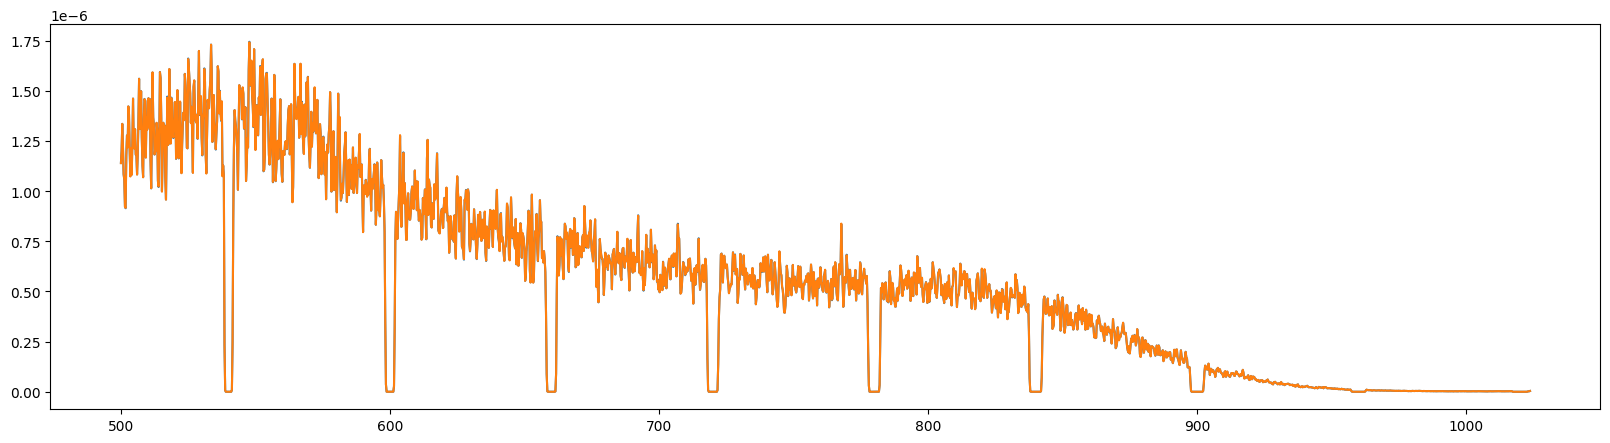

In [35]:
    


from scipy.signal import welch

def compute_psd(waveform, fs):
    """
    Compute the Power Spectral Density (PSD) of a waveform.

    Parameters:
    - waveform: np.array, the waveform signal.
    - fs: float, the sampling frequency of the waveform.

    Returns:
    - f: np.array, frequencies at which the PSD is computed.
    - psd: np.array, the estimated PSD of the waveform.
    """
    # Compute the PSD using Welch's method
    f, psd = welch(waveform, fs=fs, nperseg=fs*4)

    # Find the index of the Nyquist frequency
    nyquist_index = np.searchsorted(f, fs / 2)

    # Return frequencies and PSD values up to the Nyquist frequency
    # return f[:nyquist_index], np.log(psd[:nyquist_index])
    return f[:nyquist_index], psd[:nyquist_index]

# plot psd of the original and quantized data
freq1, psd1 = compute_psd(x1_org, 2048)
freq2, psd2 = compute_psd(x1, 2048)

s = 2000
e = 10000
plt.figure(figsize=(20, 5))
plt.plot(freq1[s:e], psd1[s:e], label='orig')
plt.plot(freq2[s:e], psd2[s:e], label='quantized')
# plt.axvline(7, color='r', linestyle='--', label='60 Hz')

In [22]:
# make a sine wave of 6 Hz 20 seconds long
t = np.arange(0, 20, 1/2048)
sine = np.sin(2 * np.pi * 60 * t)
# sine1 = np.sin(2 * np.pi * 60 * t)
# sine2 = np.sin(2 * np.pi * 90 * t)*0.01
plt.plot(t[:32], sine[:32],color='r')
plt.twinx()
i=91100
plt.plot(t[:32],eeg1[i:i+32])

MAE1: 0.00024965302695530167
MAE2: 0.00025008170693357644
MAE3: 0.0003784778471340669
MAE4: 0.0002762763946234898
MAE5: 0.0002582470558579172


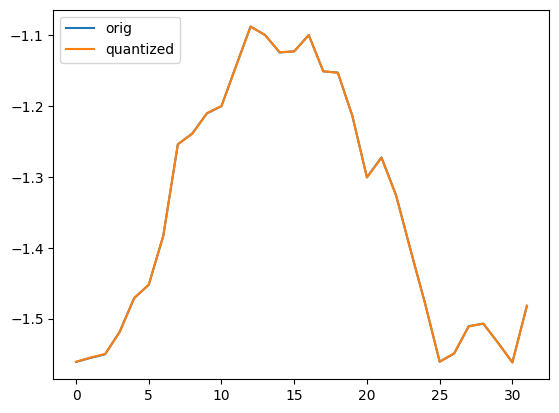

In [23]:
%matplotlib inline

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

mae1 = mae(x1_org, x1)
mae2 = mae(x2_org, x2)
mae3 = mae(x3_org, x3)
mae4 = mae(x4_org, x4)
mae5 = mae(x5_org, x5)

print(f"MAE1: {mae1}")
print(f"MAE2: {mae2}")
print(f"MAE3: {mae3}")
print(f"MAE4: {mae4}")
print(f"MAE5: {mae5}")
plt.close('all')
plt.plot(x1_org[:32], label='orig')
plt.plot(x1[:32], label='quantized')
plt.legend(loc='upper left')
plt.show()

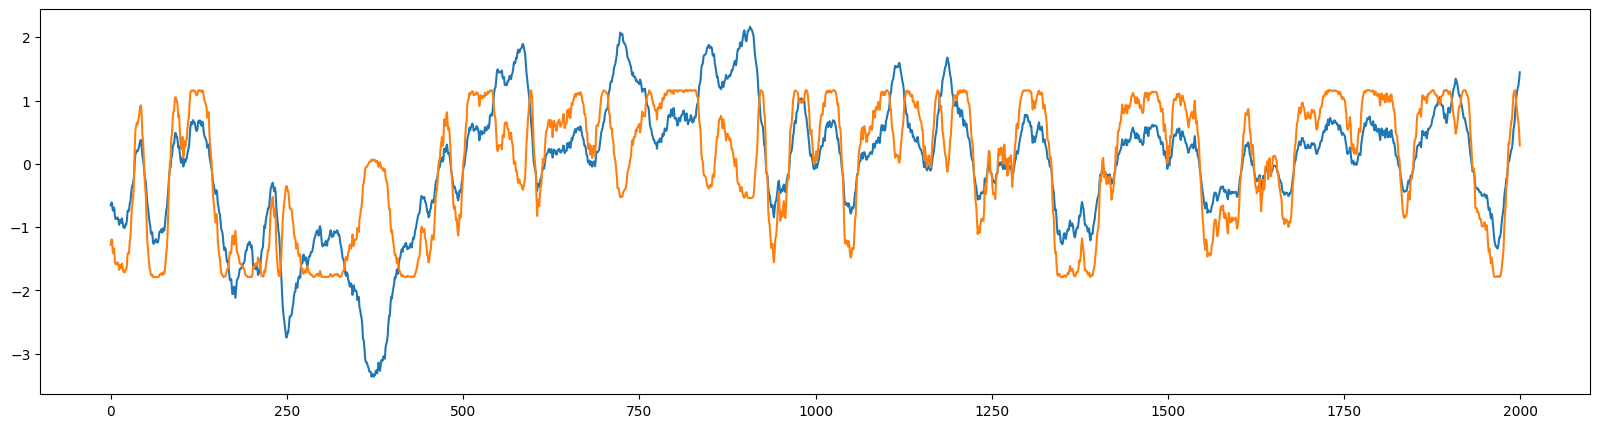

In [193]:
s = 100
e = s + 2000
plt.figure(figsize=(20, 5))
normalize = lambda x: (x - np.mean(x)) / np.std(x)
plt.plot(normalize(x1[s:e]), label='orig')

plt.plot(normalize(x4[s:e]), label='orig')
# plt.plot(x2[s:e], label='orig')
# plt.plot(x3[s:e], label='orig')
# plt.plot(x5[s:e], label='orig')


In [191]:
unique, nUnique, totalUnique = unique_waveform_values(np.expand_dims(eeg1, axis=1))
print(nUnique)
unique, nUnique, totalUnique = unique_waveform_values(np.expand_dims(eeg2, axis=1))
print(nUnique)
unique, nUnique, totalUnique = unique_waveform_values(np.expand_dims(x1, axis=1))
print(nUnique)
unique, nUnique, totalUnique = unique_waveform_values(np.expand_dims(x2, axis=1))
print(nUnique)
unique, nUnique, totalUnique = unique_waveform_values(np.expand_dims(x3, axis=1))
print(nUnique)
unique, nUnique, totalUnique = unique_waveform_values(np.expand_dims(x4, axis=1))
print(nUnique)
unique, nUnique, totalUnique = unique_waveform_values(np.expand_dims(x5, axis=1))
print(nUnique)


[7049]
[8137]
[7012]
[7849]
[6584]
[1145]
[2195]


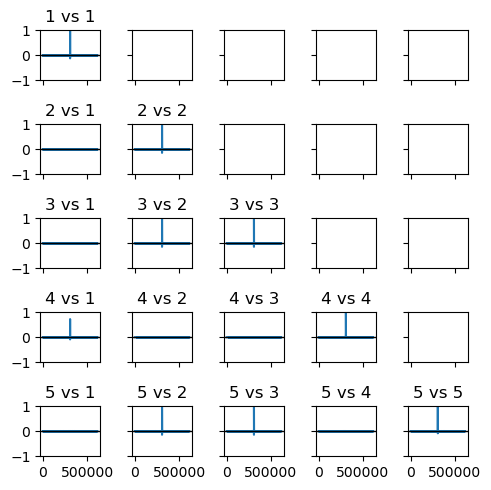

In [ ]:
%matplotlib inline

l = data.shape[1]
lst = []
names = []
comb = np.tril_indices(l, 0)
for i, j in zip(*comb):
    lst.append(ccf_values(data[:,i], data[:,j]))
    names.append(f'{i+1} vs {j+1}')

plt.close('all')
fig, ax = plt.subplots(l, l, figsize=(5, 5), sharex=True, sharey=True)
# fill lower triangle
for i in range(l):
    for j in range(l):
        if i >= j:
            ax[i, j].plot(lst.pop(0))
            ax[i, j].set_title(names.pop(0))
            ax[i, j].set_ylim(-1, 1)
            ax[i, j].axhline(0, color='black', lw=1)
plt.tight_layout()